In [ ]:
%matplotlib inline

# Assignment 5

**DUE: Sunday December 4, 2022 11:59pm**

Turn in the assignment via Canvas.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Runtime→→Restart runtime) and then run all cells (in the menubar, select Runtime→→Run All).

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWER HERE", as well as your name below:

In [ ]:
NAME = "Cole Nagao"
STUDENT_ID = "1826132"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import textwrap

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from keras import models, regularizers, layers, optimizers, losses, metrics
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, LSTM, Conv1D, MaxPooling1D, Activation, BatchNormalization
from tensorflow.keras.datasets import reuters
from tensorflow.keras.preprocessing import sequence
from keras.utils import np_utils, to_categorical
from numpy.core import numerictypes

## Question 1: Bitcoin Price Prediction
---
Bitcoin, amongst other assets like AMC and GME, has been all the rage this past two years and reached an all time high of \$68,789.63 per bitcoin. Since reaching it's high, the price has dropped 75\%. Analysts continue to feed the frenzy by releasing price predictions that range from from \$500,000 to \$9,000 per bitcoin in the next year. You will make an Recurrent Neural Network model to gain some insight into price prediction. Yahoo! Finance is a trusted name in free financial information and has been with us since the internet's early years. You'll be using data gathered obtained from https://finance.yahoo.com/quote/BTC-USD/history/ to train your recurrent neural network.

Run the following code cell to download the training and test data. It might take a while to download the zip file and extract it.

Link to the raw data: [link](https://drive.google.com/file/d/1GqHXiTMdWfNniUfF0B5TkKnvMSV1kI4b)

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1GqHXiTMdWfNniUfF0B5TkKnvMSV1kI4b'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('BTC-USD.csv')


In [ ]:
# Create pandas dataframe
data = pd.read_csv('BTC-USD.csv')

In [ ]:
# Plot data.head()
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


Let's plot the bitcoin price. First, we will make a plot of bitcoin price vs the days after September 15, 2014, the start date of this dataset. Day "0" indicates September 15, 2014.

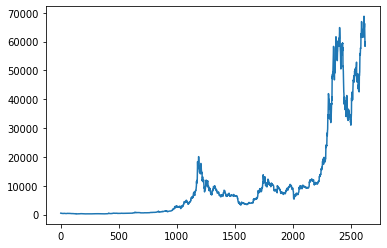

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting

g = sns.lineplot(x = np.linspace(1,2622,2622), y = data['High'].values.reshape(-1))


Next, we plot bitcoin vs. days. But this time there are dates added to the graph.

[Text(0, 0, '2014-09-17'),
 Text(0, 0, '2015-04-05'),
 Text(0, 0, '2015-10-22'),
 Text(0, 0, '2016-05-09'),
 Text(0, 0, '2016-11-25'),
 Text(0, 0, '2017-06-13'),
 Text(0, 0, '2017-12-30'),
 Text(0, 0, '2018-07-18'),
 Text(0, 0, '2019-02-03'),
 Text(0, 0, '2019-08-22'),
 Text(0, 0, '2020-03-09'),
 Text(0, 0, '2020-09-25'),
 Text(0, 0, '2021-04-13')]

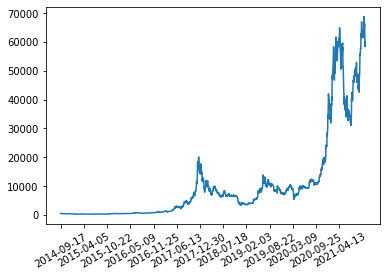

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting

g = sns.lineplot(x = np.linspace(1,2622,2622), y = data['High'].values.reshape(-1))
g.set(xticks=np.arange(0,2500,200))
g.set_xticklabels(rotation=30, labels = data['Date'][0::200])

### Part a) Data Preprocessing (5 points)
In this section you will preprocess the data in order to train a recurrent neural network. We can see that there 5 columns, "Date", "Open", "High", "Low", "Close", "Adjusted Close", and "Volume". We will only use the High column.

In [ ]:
# Create a dataframe that only contains High Column.
# Hint: it may be helpful to now cast your pruned dataframe to a numpy array.
from pandas import read_csv
# fix random seed for reproducibility
tf.random.set_seed(7)
# load the dataset
dataframe = read_csv('BTC-USD.csv', usecols=[2], engine='python')
# Remove enteries from the data with missing values. 
# The shape of the data after this step shoud be (2618,)
dataframe = dataframe.dropna()
dataset = dataframe.values
dataset = dataset.astype('float32')

Remove missing values from the data.


Recall [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from sklearn. Use it to scale the data for our analysis. 

In [ ]:
#scale the data to range between zero and one
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
print(dataset[:5])

[[0.00373944]
 [0.00357446]
 [0.00315122]
 [0.00308503]
 [0.00292653]]


You will implement a simple autoregressive recurrent neural network using the standard tensorflow RNN architectures. An autoregressive model originates from the literature on time-series models where observations from the previous time-steps are used to predict the value at the current time step. To implemement an autoregressive model, we will simply augment the data so that "time_steps" number of previous days are fed to the model at the current time step in order to form a prediction. The function to augment the data is given to you:

In [ ]:
def create_dataset(dataset, time_steps=1):
    """
    Generate a dataset where the time series X[n] contains the readings for the 'time_step' previous days 
    and y contains the price for today.
    args:
    dataset: numpy array, the data
    time_steps: the number of previous days to feed to RNN

    returns:
    tuple: a dataset with x[i] containing 'time_step' number of previous prices, target price for x[i]
    """
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# Choose the number of time steps that the model "looks back"
look_back = 1

# Produce your dataset based on the number of days the model could look back
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

### Part b) Data Partitioning (5 points)
Split data into train and test sets. Use 80\% for training and 20\% for testing. **Note**: you need to split the data in time (the begining 80\% of the days from start date will be the training data and the remaining 20\% will be test data).

In [ ]:
#did this in the last part
print(len(trainX), len(testX))
print(len(trainY), len(testY))

2092 522
2092 522


For this dataset, you need to reshape the partitions for the model to be able to process them.

In [ ]:
# Reshape input to be [samples, time steps, features].
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# The shape of the training and test data after this step should be 
# ((2618-time_steps-1) * 80%, 1, time_steps) and ((2618-time_steps-1) * 20%, 1, time_steps), respectively.
trainX.shape

(2092, 1, 1)

### Part c) RNN Model (15 points)
In this part you will create a model using an RNN layer (LSTM or GRU, unidirectional or bidirectional) and train it on your training data. You will also plot training and validation loss. Use mean squared error as your model's metric.

Compile your model and display the summary. Train the model and plot loss values.

In [ ]:
# Build your model
from tensorflow.keras.models import Sequential
### YOUR CODE HERE ###
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [ ]:
batchsize = 100
epochs =  10
# Fit model - Use 20% validation split
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2, validation_split=0.2)

Epoch 1/10
1673/1673 - 6s - loss: 0.0016 - val_loss: 1.4036e-04 - 6s/epoch - 4ms/step
Epoch 2/10
1673/1673 - 5s - loss: 1.7621e-05 - val_loss: 2.5400e-05 - 5s/epoch - 3ms/step
Epoch 3/10
1673/1673 - 5s - loss: 1.5177e-05 - val_loss: 2.4692e-05 - 5s/epoch - 3ms/step
Epoch 4/10
1673/1673 - 5s - loss: 1.5936e-05 - val_loss: 2.7195e-05 - 5s/epoch - 3ms/step
Epoch 5/10
1673/1673 - 5s - loss: 1.5372e-05 - val_loss: 7.7427e-05 - 5s/epoch - 3ms/step
Epoch 6/10
1673/1673 - 5s - loss: 1.6357e-05 - val_loss: 5.5470e-05 - 5s/epoch - 3ms/step
Epoch 7/10
1673/1673 - 5s - loss: 1.6697e-05 - val_loss: 2.3330e-05 - 5s/epoch - 3ms/step
Epoch 8/10
1673/1673 - 5s - loss: 1.6826e-05 - val_loss: 2.3786e-05 - 5s/epoch - 3ms/step
Epoch 9/10
1673/1673 - 6s - loss: 1.5097e-05 - val_loss: 3.4840e-05 - 6s/epoch - 3ms/step
Epoch 10/10
1673/1673 - 5s - loss: 1.5405e-05 - val_loss: 2.4798e-05 - 5s/epoch - 3ms/step


17/17 [==============================] - 0s 2ms/step
Train Score: 264.16 RMSE
Test Score: 4756.49 RMSE


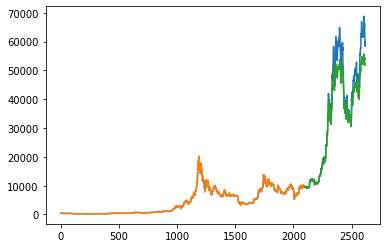

In [ ]:
from sklearn.metrics import mean_squared_error
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testY[0] = np.nan_to_num(testY[0])
testPredict[:,0] = np.nan_to_num(testPredict[:,0])
#print(testY[0])
#print(testPredict[:,0])
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Part d) More Advanced RNN Model (15 points)
In this part you will create an RNN model with the number of layers and architerure you prefer. Train it on your training data. You will also plot training and validation loss. Again, use mean squared error as your metric. In this part, you can try different models and use different hyper-parameters and report only the best one.

Compile your model and display the summary:

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 200)               161600    
                                                                 
 dense_58 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
2092/2092 - 7s - loss: 2.5358e-04 - 7s/epoch - 3ms/step
Epoch 2/10
2092/2092 - 6s - loss: 3.6175e-05 - 6s/epoch - 3ms/step
Epoch 3/10
2092/2092 - 6s - loss: 3.1911e-05 - 6s/epoch - 3ms/step
Epoch 4/10
2092/2092 - 6s - loss: 2.9106e-05 - 6s/epoch - 3ms/step
Epoch 5/10
2092/2092 - 6s - loss: 2.8311e-05 - 6s/epoch - 3ms/step
Epoch 6/10
2092/2092 - 6s - loss: 2.5734e-05 - 6s/epoch - 3ms/step
Epoch 7/10
2092/2092 - 6s - loss: 2.

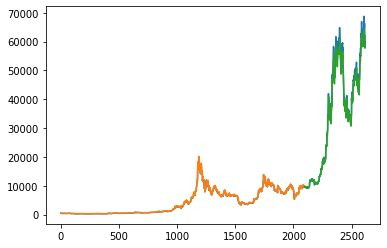

In [ ]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model2 = Sequential()
model2.add(LSTM(200, input_shape=(1, look_back)))
#model2.add(LSTM(20, return_sequences = True, input_shape=(1, look_back)))
#model2.add(LSTM(10))
#model2.add(Dense(200, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
model2.add(Dense(1))

metrics = ['accuracy']
model2.compile(loss='mean_squared_error', optimizer='rmsprop')
print(model2.summary())

model2.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

# make predictions
trainPredict = model2.predict(trainX)
testPredict = model2.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testY[0] = np.nan_to_num(testY[0])
testPredict[:,0] = np.nan_to_num(testPredict[:,0])
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Part e) Looking at the Predictions (10 points)
Now, Using the final (best) model you trained, show your model's performance on the test set. Plot the model's prediction for Bitcoin Price along with the actual test set prices. Lastly, note how your model's predictions change with your model's architecture and the number of days you "look back". Does your model perform better with more "look back days" or less. Did adding more layers help?

**Note:** Your model is trained on normalized data. In order to transform your model's predictions to the original price range you will likely need to use sklearn's inverse_transform (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

The general understanding that I got from experimenting with the model is that there were no other factors that decreased the RMSE significantly other than the number of neurons in the LSTM layer. Adding more look back days actually only increased the error. Adding more LSTM and/or more dense layers also only increased the error

Initial Score:

Train Score: 264.16 RMSE

Test Score: 4756.49 RMSE

Advanced Model Score:

Train Score: 265.13 RMSE

Test Score: 2081.76 RMSE

The graph is the one above

## Question 2: Reuters Topic Classification
---
We will use the [Reuters newswire](https://keras.io/api/datasets/reuters/) classification dataset, which has text paired with 46 topics as labels. You can see what these labels represent [here](https://martin-thoma.com/nlp-reuters/). You will analyze the text and classify the text into one of the 46 classes. Classes are the defined based on the following list (in the same order):
>```
['cocoa','grain','veg-oil','earn','acq','wheat','copper',
'housing','money-supply','coffee','sugar','trade','reserves',
'ship','cotton','carcass','crude','nat-gas','cpi','money-fx',
'interest','gnp','meal-feed','alum','oilseed','gold','tin',
'strategic-metal','livestock','retail','ipi','iron-steel',
'rubber','heat','jobs','lei','bop','zinc','orange',
'pet-chem','dlr','gas','silver','wpi','hog','lead']
```



### Part a) Processing the Data (5 points)
Load the data simply from Keras: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/reuters/load_data.
You also need to follow the RNN handout from the class exercise and prepare encoding and decoding functions and any other pre-processing you might find useful.

Print 5 examples of news along with their class label. 

In [ ]:
def encode_review(review, word_dict, maxlen):
  encoded_review = []
  for raw_word in review.split(' '):
    word = raw_word.strip().strip(string.punctuation).lower()
    if word is '' or word is '\n':
      continue
    try:
      encoded_review.append(word_dict[word])
    except KeyError as e:
      # raise KeyError(f'{e} not in word dictionary, review not encoded.')
      continue
  return pad_sequences(np.array(encoded_review).reshape(1,-1), maxlen=maxlen)

def decode_review(encoded_review, inverse_word_dict):
  sentence = []
  for encoded_word in encoded_review:
    if encoded_word == 0:
      continue
    sentence.append(inverse_word_dict[encoded_word])
  w = textwrap.TextWrapper(width=120,break_long_words=False,replace_whitespace=False)
  return '\n'.join(w.wrap(' '.join(sentence)))

In [ ]:
# Load data
### YOUR CODE HERE ###
num_classes = 46
max_sequence_len = 5000
num_words=5000

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.reuters.load_data(
    path='reuters.npz',
    num_words= num_words,
    skip_top=0,
    maxlen=max_sequence_len,
    test_split=0.2,
    seed=113,
    start_char=1,
    oov_char=2,
    index_from=3,
)

In [ ]:
# Clean and pre-process the data
word_dict = reuters.get_word_index()
for i in range(50):
  for key, value in word_dict.items(): 
    if value == i:
        print('(', key, ',', value, ')', sep = '', end = ',')

print()
print(len(word_dict))

word_dict = {k:(v+3) for k,v in word_dict.items()}
word_dict["<PAD>"] = 0
word_dict["<START>"] = 1
word_dict["<UNK>"] = 2
word_dict["<UNUSED>"] = 3

vocab_size = len(word_dict.keys())
print('Number of words in vocabulary: ', vocab_size)
for i in range(50):
  for key, value in word_dict.items(): 
    if value == i:
        print('(', key, ',', value, ')', sep = '', end = ',')

inverse_word_dict = {value:key for key,value in word_dict.items()}

In [ ]:
print(len(X_train), len(X_test))

8982 2246


In [ ]:
X_train = pad_sequences(X_train, maxlen=num_words)
X_test = pad_sequences(X_test, maxlen=num_words)

In [ ]:
one_hot_y_train = to_categorical(y_train)
one_hot_y_test = to_categorical(y_test)

In [ ]:
# Print sample data
for i in range(0, 4):
  print(decode_review(X_train[i], inverse_word_dict), end='\n\n')
  print('Sentiment: ', y_train[i], class_names[y_train[i]], end='\n\n')

<START> <UNK> <UNK> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1
15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six
mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this
year should be 2 50 to three dlrs reuter 3

Sentiment:  3 earn

<START> generale de banque sa lt <UNK> <UNK> and lt heller overseas corp of chicago have each taken 50 pct stakes in
<UNK> company sa <UNK> factors generale de banque said in a statement it gave no financial details of the transaction sa
<UNK> <UNK> turnover in 1986 was 17 5 billion belgian francs reuter 3

Sentiment:  4 acq

<START> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln
year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1
mln note 

### Part b) Data Partitioning (5 points)

Split data into train and test sets. Please use 80% for training and 20% for testing. Note that we want to have the same distribution of labels in the training and test set, so you can use stratified train-test split of Keras. See here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:
#this is done already when loading in the data
print(len(X_train), len(X_test))

8982 2246


### Part c) Simple RNN Model (15 points)

Create a model using an RNN layer (LSTM or GRU, unidirectional or bidirectional) and train it on your training data. You will also plot training and validation loss and your accuracy metric.

Compile your model and display the summary:

In [ ]:
from numpy.core import numerictypes
from tensorflow.keras.models import Sequential
# Build your model
input_layer = Input(shape=(max_sequence_len))
x = Embedding(vocab_size, 200)(input_layer)

x = LSTM(4)(x) 
x = Dense(20, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)
sentiment_model = Model(input_layer, x)

metrics = ['accuracy']

sentiment_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=metrics)

print(sentiment_model.summary())

batchsize = 50
epochs =  5

# Fit model
history = sentiment_model.fit(X_train, one_hot_y_train, batch_size=batchsize, epochs=epochs, validation_split=0.2, shuffle=True)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 5000)]            0         
                                                                 
 embedding_29 (Embedding)    (None, 5000, 200)         6196600   
                                                                 
 lstm_29 (LSTM)              (None, 4)                 3280      
                                                                 
 dense_55 (Dense)            (None, 20)                100       
                                                                 
 dense_56 (Dense)            (None, 46)                966       
                                                                 
Total params: 6,200,946
Trainable params: 6,200,946
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
144/144 [========================

In [ ]:
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

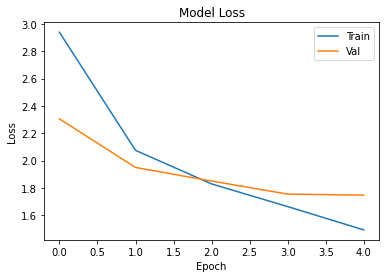

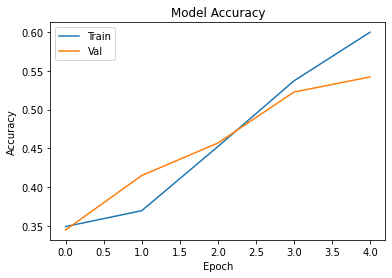

In [ ]:
# Plot the model loss and accuracy on training and validation sets

### YOUR CODE HERE ###
plot_losses(history)
plot_accuracies(history)

You can get surprisingly good results from just a little, but thats also because one of the classes makes up like 40% of the test set, and that is representitive of the dataset in general too

### Part d) More Advanced RNN Model (15 points)
In this part, you will create an RNN model with the number of layers and architerure you prefer. Train it on your training data. You will also plot training and validation loss and your metric. In this part, you can try different models and use different hyper-parameters and report only the best one.

In [ ]:
# load the dataset again so it is easier to play with the shape of the dataset
tf.random.set_seed(113)
top_words = 5000
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=top_words)
max_review_length = 5000
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
one_hot_y_train = to_categorical(y_train)
one_hot_y_test = to_categorical(y_test)

In [ ]:
#building the model
#I decided to try using some convolutional layers too
embedding_vecor_length = 100
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Conv1D(filters=embedding_vecor_length, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(120)) 
model.add(Dense(46, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train, one_hot_y_train, epochs=10, batch_size=200, validation_split=0.2, shuffle=True)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 5000, 100)         500000    
                                                                 
 conv1d_16 (Conv1D)          (None, 5000, 100)         30100     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 2500, 100)        0         
 g1D)                                                            
                                                                 
 lstm_26 (LSTM)              (None, 120)               106080    
                                                                 
 dense_50 (Dense)            (None, 46)                5566      
                                                                 
Total params: 641,746
Trainable params: 641,746
Non-trainable params: 0
_______________________________________________

Compile your model and display the summary:

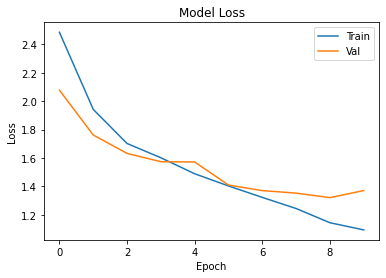

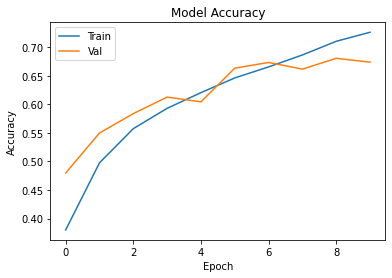

In [ ]:
plot_losses(history)
plot_accuracies(history)

I'm pretty sure this is the upper limit of what can be done on this data set without overfitting any more layers, neurons, or epochs just cause a diveregence of the train and test loss/accuracy. This is most definitely because the data set is skewed to have a lot of examples of only a few categories like earn

### Part e) Looking at the Predictions (10 points)

Now, Using the final (best) model you trained, show your model's performance on the test set.
Calculate and display the prediction accuracy for all of the 46 different classes. 

In [ ]:
class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper',
'housing','money-supply','coffee','sugar','trade','reserves',
'ship','cotton','carcass','crude','nat-gas','cpi','money-fx',
'interest','gnp','meal-feed','alum','oilseed','gold','tin',
'strategic-metal','livestock','retail','ipi','iron-steel',
'rubber','heat','jobs','lei','bop','zinc','orange',
'pet-chem','dlr','gas','silver','wpi','hog','lead']

In [ ]:
trainPredict = model.predict(X_test)

trainPredict = np.array(trainPredict)
y_pred = np.argmax(a = trainPredict, axis= 1)
correct = [0]*46
total = [0]*46
total_pred = [0]*46
for i in range(0, len(y_pred)):
  total[y_test[i]] = total[y_test[i]] + 1
  total_pred[y_pred[i]] = total_pred[y_pred[i]] + 1
  if y_pred[i] == y_test[i]:
    correct[y_test[i]] = correct[y_test[i]] + 1
# this is all the input into the accuracy
# it is quite helpful for analyzing the data set
#print(total)
#print(total_pred)
#print(correct)
for i in range(0, len(class_names)):
  # can either print the names or the numbers
  # I printed nums just because I dont wanna format it better
  #print(class_names[i], f'\t\t% correct = {correct[i]/total[i] *100:.2f}')
  print(i, f'\t\t% correct = {correct[i]/total[i] *100:.2f}')

71/71 [==============================] - 3s 44ms/step
2246
2246
0 		% correct = 0.00
1 		% correct = 56.19
2 		% correct = 5.00
3 		% correct = 95.33
4 		% correct = 85.44
5 		% correct = 0.00
6 		% correct = 0.00
7 		% correct = 0.00
8 		% correct = 0.00
9 		% correct = 0.00
10 		% correct = 16.67
11 		% correct = 71.08
12 		% correct = 0.00
13 		% correct = 24.32
14 		% correct = 0.00
15 		% correct = 0.00
16 		% correct = 65.66
17 		% correct = 0.00
18 		% correct = 45.00
19 		% correct = 16.54
20 		% correct = 30.00
21 		% correct = 29.63
22 		% correct = 0.00
23 		% correct = 0.00
24 		% correct = 0.00
25 		% correct = 9.68
26 		% correct = 0.00
27 		% correct = 0.00
28 		% correct = 0.00
29 		% correct = 0.00
30 		% correct = 0.00
31 		% correct = 0.00
32 		% correct = 0.00
33 		% correct = 0.00
34 		% correct = 14.29
35 		% correct = 0.00
36 		% correct = 0.00
37 		% correct = 0.00
38 		% correct = 0.00
39 		% correct = 0.00
40 		% correct = 0.00
41 		% correct = 0.00
42 		% cor

What you can notice is that the accuracy of the model is dependent on how many examples there are for the categories. This suggests that in general there is just not enough data relative to the number of categories, a handful of examples per category is just not enough to train any model to be able to accurately decipher the category

# You can ignore this part

this is just some experiments without using LSTM, the model is actually just as good it just doesnt fit within the parameters of the assignment, I just wanna leave it here for future reference

In [ ]:
def vectorize_sequences(sequences, dimension=num_words):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [ ]:
from tensorflow.keras.models import Sequential
from keras import regularizers

x_train = vectorize_sequences(X_train)
x_test = vectorize_sequences(X_test)

model = Sequential()
model.add(Dense(256, kernel_regularizer=regularizers.l1(0.001), activation='relu',input_shape=(num_words,)))
model.add(Dropout(0.5))
model.add(Dense(256, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(46, activation='softmax'))
model.summary()
batchsize = 300
epochs =  10
metrics = ['accuracy']

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=metrics)
history = model.fit(x_train, one_hot_y_train, batch_size=batchsize, epochs=epochs, validation_split=0.2, shuffle=True)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_47 (Dense)            (None, 256)               1280256   
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 dense_48 (Dense)            (None, 256)               65792     
                                                                 
 dropout_26 (Dropout)        (None, 256)               0         
                                                                 
 dense_49 (Dense)            (None, 46)                11822     
                                                                 
Total params: 1,357,870
Trainable params: 1,357,870
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
24/24 [=========================

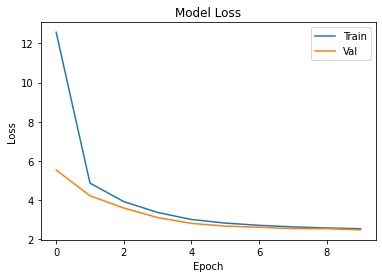

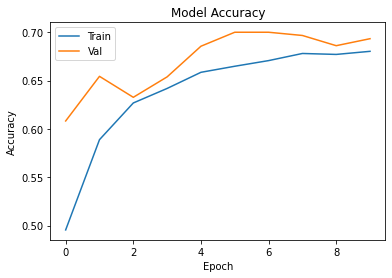

In [ ]:
# Plot the model loss and accuracy

### YOUR CODE HERE ###
plot_losses(history)
plot_accuracies(history)

In [ ]:
model = models.Sequential()
model.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.001), activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(46, activation='softmax'))
model.summary()